## Interpretation of models trained on UniProtKB Coronaviridae S protein dataset for multiclass classification

### Sequences used for analysis
SARS-Cov-2 S protein sequences infecting humans: n=1311

Sequences aligned using MAFFT along with the Wuhan Index S protein sequence

Selected sequences aligned (without any gaps) with the Wuhan Index S protein sequence with sequence length = 1273

Number of sequences  = 1039

In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

['/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python310.zip',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/lib-dynload',
 '',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/PyQt5_sip-12.11.0-py3.10-linux-x86_64.egg',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/../../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/..']

In [6]:
from models.nlp.transformer import transformer, transformer_model
from models.nlp import cnn1d, lstm
from models.nlp.fnn import fnn
from datasets.protein_sequence_dataset import ProteinSequenceDataset
from src.utils import utils, nn_utils
from models.nlp.embedding.padding import Padding

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve, accuracy_score, f1_score, auc, precision_recall_curve
from statistics import mean

from captum.attr import LayerIntegratedGradients, TokenReferenceBase, LayerGradientXActivation, LayerDeepLift, LayerLRP

In [99]:
label_groupings = {
                    "Pig": [ "Sus scrofa (Pig) [TaxID: 9823]" ],
                    "Human": [ "Homo sapiens (Human) [TaxID: 9606]" ],
                    "Wild turkey": [ "Meleagris gallopavo (Wild turkey) [TaxID: 9103]" ],
                    "Japanese pipistrelle": [ "Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]" ],
                    "Lesser bamboo bat": [ "Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]" ],
                    "Chicken": [ "Gallus gallus (Chicken) [TaxID: 9031]" ],
                    "Bovine": [ "Bos taurus (Bovine) [TaxID: 9913]" ]
                }

amino_acid_idx_map = {'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5,
                  'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10,
                  'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15,
                  'O': 16, 'S': 17, 'U': 18, 'T': 19, 'W': 20,
                  'Y': 21, 'V': 22, 'B': 23, 'Z': 24, 'X': 25,
                  'J': 26}
idx_amino_acid_map = {v:k for k,v in amino_acid_idx_map.items()}

train_sequence_settings =  {
    "sequence_col": "seq",
    "batch_size": 8,
    "max_sequence_length": 1273,
    "pad_sequence_val": 0,
    "truncate": True,
    "feature_type": "token"
}

test_sequence_settings =  train_sequence_settings.copy()
test_sequence_settings["batch_size"] = 1

label_settings = {
    "label_col": "virus_host",
    "exclude_labels": [ "nan"],
    "label_groupings":  label_groupings
}

model = {
    "max_seq_len": 1453,
    "loss": "CrossEntropyLoss",
    "with_convolution": False,
    "n_heads": 8,
    "depth": 6,
    "n_tokens": 27,
    "n_classes": 7,
    "n_epochs": 10,
    "input_dim": 512, # input embedding dimension
    "hidden_dim": 1024
}

### Load the datasets

In [92]:
def get_token_dataset_loader(df, sequence_settings, label_settings):
    label_col = label_settings["label_col"]
    
    seq_col = sequence_settings["sequence_col"]
    batch_size = sequence_settings["batch_size"]
    max_seq_len = sequence_settings["max_sequence_length"]
    pad_sequence_val = sequence_settings["pad_sequence_val"]
    truncate = sequence_settings["truncate"]
    
    df = df[[seq_col, label_col]]
    df, index_label_map = utils.transform_labels(df, label_settings, classification_type="multi")
    
    dataset = ProteinSequenceDataset(df, seq_col, max_seq_len, truncate, label_col)
    return index_label_map, DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True,
                      collate_fn=Padding(max_seq_len, pad_sequence_val))

def print_dataset_loader(dataset_loader):
    sequence, label = next(iter(dataset_loader))
    print(f"Sequence tensor size = {sequence.shape}")
    print(f"Sequence = {sequence}")
    print(f"Label tensor size = {label.shape}")
    print(f"Label = {label}")

In [93]:
uniprotkb_sarscov2_human_df = pd.read_csv("/home/grads/blessyantony/dev/git/zoonosis/input/data/coronaviridae/sarscov2_top_7_hosts_human_aligned_1273.csv")
uniprotkb_sarscov2_human_df.head()

,id,seq,virus,seq_len,virus_host,binary_label
0,P0DTC2,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,Severe acute respiratory syndrome coronavirus ...,1273,Homo sapiens (Human) [TaxID: 9606],Human
1,A0A679G9E9,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,Severe acute respiratory syndrome coronavirus ...,1273,Homo sapiens (Human) [TaxID: 9606],Human
2,A0A6B9XJC0,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,Severe acute respiratory syndrome coronavirus ...,1273,Homo sapiens (Human) [TaxID: 9606],Human
3,A0A6C0QGH5,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,Severe acute respiratory syndrome coronavirus ...,1273,Homo sapiens (Human) [TaxID: 9606],Human
4,A0A6C0RQ44,MFVFLVLLPLVSSQCVNLTTRTQLPPANTNSFTRGVYYPDKVFRSS...,Severe acute respiratory syndrome coronavirus ...,1273,Homo sapiens (Human) [TaxID: 9606],Human


In [94]:
uniprotkb_sarscov2_human_df["virus_host"].value_counts()

Homo sapiens (Human) [TaxID: 9606]    1038
Name: virus_host, dtype: int64

In [95]:
def get_target_dataset_loader(target):
    uniprotkb_coronaviruses_target_df = uniprotkb_sarscov2_human_df[uniprotkb_sarscov2_human_df["virus_host"] == target]
    print(f"Size {target} df = {uniprotkb_coronaviruses_target_df.shape}")
    return get_token_dataset_loader(uniprotkb_coronaviruses_target_df, test_sequence_settings, label_settings)

In [96]:
index_label_map, sarscov2_dataset_loader = get_token_dataset_loader(uniprotkb_sarscov2_human_df, test_sequence_settings, label_settings)

Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/../../../src/utils/utils.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/../../../src/utils/utils.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/../../datasets/protein_sequence_dataset.py:29: SettingWithCopyW

### Load the trained models

#### Model: TF trained on Coronaviridae S protein dataset
#### Training Dataset: UniProtKB Coronaviridae 5K (coronaviridae_top_7_hosts.csv)
#### max sequence length: 1453


In [97]:
models_dir = "/home/grads/blessyantony/dev/git/zoonosis/output/raw/coronaviridae/20230908"

#### CNN Model

In [98]:
model["kernel_size"] = 3
model["stride"] = 1
model["depth"] = 4
cnn_model = cnn1d.get_cnn_model(model)
cnn_model.load_state_dict(torch.load(os.path.join(models_dir, "host_multi_lr1e-3-e50", "cnn-l_4-lr1e-3_itr0.pth")))
cnn_model = cnn_model.to(nn_utils.get_device())
cnn_model.eval()
cnn_model.zero_grad()

CNN_1D_Model(
  (embedding): EmbeddingLayer(
    (token_embedding): Embedding(27, 512)
    (positional_embedding): PositionalEncoding()
  )
  (conv1d): Conv1d(512, 1024, kernel_size=(3,), stride=(1,))
  (conv1d_hidden): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,))
  (conv1d_hidden_layers): ModuleList(
    (0-2): 3 x Conv1d(1024, 1024, kernel_size=(3,), stride=(1,))
  )
  (linear): Linear(in_features=1024, out_features=7, bias=True)
)
Number of parameters =  14181895


RuntimeError: Error(s) in loading state_dict for CNN_1D_Model:
	size mismatch for embedding.positional_embedding.pos_enc: copying a param with shape torch.Size([1, 1453, 512]) from checkpoint, the shape in current model is torch.Size([1, 1273, 512]).

#### LSTM Model

In [15]:
model["depth"] = 2
lstm_model = lstm.get_lstm_model(model)
lstm_model.load_state_dict(torch.load(os.path.join(models_dir, "host_multi_lr1e-3-e50", "lstm-l_2-lr1e-3_itr0.pth")))
lstm_model = lstm_model.to(nn_utils.get_device())

LSTM_Model(
  (embedding): EmbeddingLayer(
    (token_embedding): Embedding(27, 512)
    (positional_embedding): PositionalEncoding()
  )
  (lstm): LSTM(512, 1024, num_layers=2, batch_first=True)
  (linear): Linear(in_features=1024, out_features=7, bias=True)
)
Number of parameters =  14717447


#### TF - Pytorch Model

In [16]:
model["depth"] = 6
tf_pytorch_model = transformer_model.get_transformer_model(model)
tf_pytorch_model.load_state_dict(torch.load(os.path.join(models_dir, "host_multi_lr1e-4-e50", "transformer-l_6-h_8-lr1e-4_itr0.pth")))
tf_pytorch_model = tf_pytorch_model.to(nn_utils.get_device())
tf_pytorch_model.eval()
tf_pytorch_model.zero_grad()

TransformerModel(
  (embedding): EmbeddingLayer(
    (token_embedding): Embedding(27, 512)
    (positional_embedding): PositionalEncoding()
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear(in_features=1024, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.0, inplace=False)
        (dropout2): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (linear): Linear(in_features=512, out_features=7, bias=True)
)
Number of parameters =  12634119


#### TF - Custom Model

In [17]:
model["depth"] = 6
tf_custom_model = transformer.get_transformer_model(model)
tf_custom_model.load_state_dict(torch.load(os.path.join(models_dir, "host_multi_lr1e-4-e50", "transformer-custom-l_6-h_8-lr1e-4_itr0.pth")))
tf_custom_model = tf_custom_model.to(nn_utils.get_device())
tf_custom_model.eval()
tf_custom_model.zero_grad()

Transformer(
  (embedding): EmbeddingLayer(
    (token_embedding): Embedding(27, 512)
    (positional_embedding): PositionalEncoding()
  )
  (encoder): Encoder(
    (layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (self_attn): MultiHeadAttention(
          (W_Q): Linear(in_features=512, out_features=512, bias=True)
          (W_K): Linear(in_features=512, out_features=512, bias=True)
          (W_V): Linear(in_features=512, out_features=512, bias=True)
          (W_O): Linear(in_features=512, out_features=512, bias=True)
        )
        (feed_forward): FeedForwardLayer(
          (W_1): Linear(in_features=512, out_features=1024, bias=True)
          (W_2): Linear(in_features=1024, out_features=512, bias=True)
        )
        (residual_connections): ModuleList(
          (0-1): 2 x ResidualConnectionLayer(
            (norm): NormalizationLayer()
          )
        )
      )
    )
    (norm): NormalizationLayer()
  )
  (linear): Linear(in_features=512, out_features=7, b

### Prediction Performance

In [18]:
def validate(model, dataset_loader):
    with torch.no_grad():
        model.eval()

        results = []

        for _, data in enumerate(dataset_loader):
            # get input and labels; data is a list of [(inputs, labels)]
            inputs, labels = data

            output = model(inputs)

            # tensorboard + logs

            # to get probabilities of the output
            output = F.softmax(output, dim=-1)
            result_df = pd.DataFrame(output.cpu().numpy())
            result_df["y_true"] = labels.cpu().numpy()
            results.append(result_df)
    
    return pd.concat(results, ignore_index=True)

In [20]:
results = validate(tf_custom_model, sarscov2_dataset_loader)

In [21]:
results_df = results.rename(columns=index_label_map)
results_df["y_true"] = results_df["y_true"].map(lambda x: index_label_map[x])
results_df

,Bovine,Chicken,Human,Japanese pipistrelle,Lesser bamboo bat,Pig,Wild turkey,y_true
0,0.002391,0.000050,0.932128,0.000055,0.000108,0.013560,0.051709,Human
1,0.002101,0.000010,0.971734,0.000043,0.000182,0.003558,0.022373,Human
2,0.002007,0.000014,0.963944,0.000039,0.000156,0.004252,0.029588,Human
3,0.002367,0.000011,0.968581,0.000040,0.000190,0.003413,0.025398,Human
4,0.002394,0.000050,0.932045,0.000055,0.000108,0.013570,0.051778,Human
...,...,...,...,...,...,...,...,...
1033,0.002241,0.000015,0.959074,0.000037,0.000164,0.004226,0.034243,Human
1034,0.002094,0.000010,0.971338,0.000042,0.000180,0.003593,0.022743,Human
1035,0.002105,0.000013,0.964290,0.000038,0.000167,0.003963,0.029425,Human
1036,0.002190,0.000018,0.956179,0.000038,0.000150,0.004860,0.036565,Human


In [22]:
auprcs = []
for i in index_label_map.values():
    precision, recall, _ = precision_recall_curve(y_true=results_df["y_true"].values, probas_pred=results_df[i].values, pos_label=i)
    auprc = auc(recall, precision)
    print(f"AUPRC for class {i} = {auprc}")
    auprcs.append(auprc)

macro_auprc = mean(auprcs)
print(f"Macro AUPRC = {macro_auprc}")

AUPRC for class Bovine = 0.5
AUPRC for class Chicken = 0.5
AUPRC for class Human = 1.0
AUPRC for class Japanese pipistrelle = 0.5
AUPRC for class Lesser bamboo bat = 0.5
AUPRC for class Pig = 0.5
AUPRC for class Wild turkey = 0.5
Macro AUPRC = 0.5714285714285714


/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No posit

## Intepretation

In [23]:
def compute_top_n_positions(attr_df, n):
    attr_rank_df = attr_df.abs().rank("columns", ascending=False).astype(int)
    # retain only top n ranks
    attr_rank_df[attr_rank_df > n] = None
    # drop all columns (positions) with all NaN i.e. this position is not in the top 10 for any sequence
    attr_rank_df.dropna(axis=1, how="all", inplace=True)
    print(attr_rank_df.columns)
    print(attr_rank_df.head(20))
    sns.heatmap(data=attr_df[attr_rank_df.columns])
    plt.show()

#### Inputs

In [58]:
human_inputs = []
_, human_dataset_loader = get_target_dataset_loader("Homo sapiens (Human) [TaxID: 9606]")
for i in range(len(human_dataset_loader)):
    human_inputs.append(next(iter(human_dataset_loader)))

Size Homo sapiens (Human) [TaxID: 9606] df = (1038, 6)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/../../../src/utils/utils.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/../../../src/utils/utils.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/../../datasets/protein_sequence_dataset.py:29: SettingWithCopyW

In [59]:
human_input = next(iter(human_dataset_loader))

#### Outputs

In [60]:
n_attr_dfs = []
single_seq_attr_dfs = []

### LayerGradientXActivation

In [61]:
def compute_lgxa_attributions(model, inputs, target):
    attributions = []
    for seq, label in inputs:
        interpreter = LayerGradientXActivation(model, model.embedding)
        attribution = interpreter.attribute(seq, target=target)
        
        attribution = attribution.sum(dim=2).squeeze(0)
        attribution = attribution / torch.norm(attribution)
        attributions.append(attribution.detach().cpu().numpy())
    return pd.DataFrame(attributions)

In [62]:
n_attr_dfs.append({
    "model": "CNN",
    "method": "LayerGradientXActivation",
    "class": "Human",
    "attr_df": compute_lgxa_attributions(cnn_model, human_inputs, target=2)
})

In [63]:
n_attr_dfs.append({
    "model": "LSTM",
    "method": "LayerGradientXActivation",
    "class": "Human",
    "attr_df": compute_lgxa_attributions(lstm_model, human_inputs, target=2)
})

In [64]:
single_seq_attr_dfs.append({
    "model": "CNN",
    "method": "LayerGradientXActivation",
    "class": "Human",
    "attr_df": compute_lgxa_attributions(cnn_model, [human_input], target=2)
})

In [65]:
single_seq_attr_dfs.append({
    "model": "LSTM",
    "method": "LayerGradientXActivation",
    "class": "Human",
    "attr_df": compute_lgxa_attributions(lstm_model, [human_input], target=2)
})

### LayerIntegratedGradients

In [66]:
def compute_lig_attributions(model, inputs, target, reference_seq):
    attributions = []
    for seq, label in inputs:
        interpreter = LayerIntegratedGradients(model, model.embedding)
        attribution = interpreter.attribute(seq, reference_seq, target=target)
        
        attribution = attribution.sum(dim=2).squeeze(0)
        attribution = attribution / torch.norm(attribution)
        attributions.append(attribution.detach().cpu().numpy())
    return pd.DataFrame(attributions)

In [67]:
reference_seq = TokenReferenceBase(reference_token_idx=0).generate_reference(test_sequence_settings["max_sequence_length"],
                                                                       device=nn_utils.get_device()).unsqueeze(0)
n_attr_dfs.append({
    "model": "CNN",
    "method": "LayerIntegratedGradients",
    "class": "Human",
    "attr_df": compute_lig_attributions(cnn_model, human_inputs, target=2, reference_seq=reference_seq)
})

In [68]:
reference_seq = TokenReferenceBase(reference_token_idx=0).generate_reference(test_sequence_settings["max_sequence_length"],
                                                                       device=nn_utils.get_device()).unsqueeze(0)
n_attr_dfs.append({
    "model": "LSTM",
    "method": "LayerIntegratedGradients",
    "class": "Human",
    "attr_df": compute_lig_attributions(lstm_model, human_inputs, target=2, reference_seq=reference_seq)
})

In [69]:
reference_seq = TokenReferenceBase(reference_token_idx=0).generate_reference(test_sequence_settings["max_sequence_length"],
                                                                       device=nn_utils.get_device()).unsqueeze(0)
single_seq_attr_dfs.append({
    "model": "CNN",
    "method": "LayerIntegratedGradients",
    "class": "Human",
    "attr_df": compute_lig_attributions(cnn_model, [human_input], target=2, reference_seq=reference_seq)
})

In [70]:
reference_seq = TokenReferenceBase(reference_token_idx=0).generate_reference(test_sequence_settings["max_sequence_length"],
                                                                       device=nn_utils.get_device()).unsqueeze(0)
single_seq_attr_dfs.append({
    "model": "LSTM",
    "method": "LayerIntegratedGradients",
    "class": "Human",
    "attr_df": compute_lig_attributions(lstm_model, [human_input], target=2, reference_seq=reference_seq)
})

### LayerDeepLift

In [71]:
def compute_ldeeplift_attributions(model, inputs, reference_seq, target):
    attributions = []
    for seq, label in inputs:
        interpreter = LayerDeepLift(model, model.embedding)
        attribution = interpreter.attribute(seq, baselines=reference_seq, target=target)
        
        attribution = attribution.sum(dim=2).squeeze(0)
        attribution = attribution / torch.norm(attribution)
        attributions.append(attribution.detach().cpu().numpy())
    return pd.DataFrame(attributions)

In [72]:
reference_seq = TokenReferenceBase(reference_token_idx=0).generate_reference(test_sequence_settings["max_sequence_length"],
                                                                       device=nn_utils.get_device()).unsqueeze(0)
n_attr_dfs.append({
    "model": "CNN",
    "method": "LayerDeepLift",
    "class": "Human",
    "attr_df": compute_ldeeplift_attributions(cnn_model, human_inputs, reference_seq, target=2)
})

In [73]:
reference_seq = TokenReferenceBase(reference_token_idx=0).generate_reference(test_sequence_settings["max_sequence_length"],
                                                                       device=nn_utils.get_device()).unsqueeze(0)
n_attr_dfs.append({
    "model": "LSTM",
    "method": "LayerDeepLift",
    "class": "Human",
    "attr_df": compute_ldeeplift_attributions(lstm_model, human_inputs, reference_seq, target=2)
})

In [74]:
single_seq_attr_dfs.append({
    "model": "CNN",
    "method": "LayerDeepLift",
    "class": "Human",
    "attr_df": compute_ldeeplift_attributions(cnn_model, [human_input], reference_seq, target=2)
})

In [75]:
single_seq_attr_dfs.append({
    "model": "LSTM",
    "method": "LayerDeepLift",
    "class": "Human",
    "attr_df": compute_ldeeplift_attributions(lstm_model, [human_input], reference_seq, target=2)
})

### Attention - Only for Transformer

In [76]:
def compute_attention_attributions(tf_model, inputs):
    tf_model.eval()
    attn_dfs = []
    
    for seq, label in inputs:
        tf_model(seq)
        attn_values = tf_model.encoder.layers[5].self_attn.self_attn.squeeze()
        mean_attn_values = torch.mean(attn_values, dim=0)
        mean_of_mean = torch.mean(mean_attn_values, dim=0, keepdim=True)
        df = pd.DataFrame(mean_of_mean.cpu().detach().numpy())
        attn_dfs.append(df)

    return pd.concat(attn_dfs, axis=0)

In [77]:
n_attr_dfs.append({
    "model": "TF",
    "method": "Attention",
    "class": "Human",
    "attr_df": compute_attention_attributions(tf_custom_model, human_inputs)
})


In [78]:
single_seq_attr_dfs.append({
    "model": "TF",
    "method": "Attention",
    "class": "Human",
    "attr_df": compute_attention_attributions(tf_custom_model, [human_input])
})


### LayerLRP

In [46]:
def compute_llrp_attributions(model, inputs, target):
    attributions = []
    for seq, label in inputs:
        interpreter = LayerLRP(model, model.embedding)
        attribution = interpreter.attribute(seq, target=target)
        
        attribution = attribution.sum(dim=2).squeeze(0)
        attribution = attribution / torch.norm(attribution)
        attributions.append(attribution.detach().cpu().numpy())
    return pd.DataFrame(attributions)


def compute_target_llrp_attributions(model, model_name, target, n=10):
    _, human_dataset_loader = get_target_dataset_loader(target)
    inputs = []
    for i in range(n):
        inputs.append(next(iter(human_dataset_loader)))
    interpret_results_df = compute_llrp_attributions(model, inputs, target=2)
    plot_top_n_attr(interpret_results_df, n=10)

In [ ]:
compute_target_llrp_attributions(cnn_model, "CNN", target="Homo sapiens (Human) [TaxID: 9606]", n=10)

In [ ]:
compute_target_llrp_attributions(lstm_model, "LSTM", target="Homo sapiens (Human) [TaxID: 9606]", n=10)
compute_target_llrp_attributions(lstm_model, "LSTM", target="Sus scrofa (Pig) [TaxID: 9823]", n=10)

### Visualization for n=20 Human sequences

In [79]:
n_attr_dfs

[{'model': 'CNN',
  'method': 'LayerGradientXActivation',
  'class': 'Human',
  'attr_df':           0         1         2         3         4         5         6     \
  0    -0.004157  0.021421 -0.034626 -0.002961 -0.025662  0.021099  0.026294   
  1    -0.004157  0.021421 -0.034626 -0.002961 -0.025686  0.021061  0.026042   
  2    -0.004157  0.021419 -0.034623 -0.002960 -0.025659  0.021097  0.026292   
  3    -0.004157  0.021422 -0.034628 -0.002961 -0.025663  0.021100  0.026295   
  4    -0.004157  0.021421 -0.034625 -0.002961 -0.025661  0.021098  0.026293   
  ...        ...       ...       ...       ...       ...       ...       ...   
  1033 -0.004157  0.021421 -0.034625 -0.002961 -0.025686  0.021061  0.026042   
  1034 -0.008898  0.045848 -0.074110 -0.006337 -0.054977  0.045078  0.055738   
  1035 -0.004157  0.021421 -0.034625 -0.002961 -0.025661  0.021098  0.026293   
  1036 -0.004157  0.021421 -0.034625 -0.002961 -0.025686  0.021061  0.026042   
  1037 -0.004157  0.021422 -0.0

#### Attribution values for n=20 sequences for all model-method combinations - Human

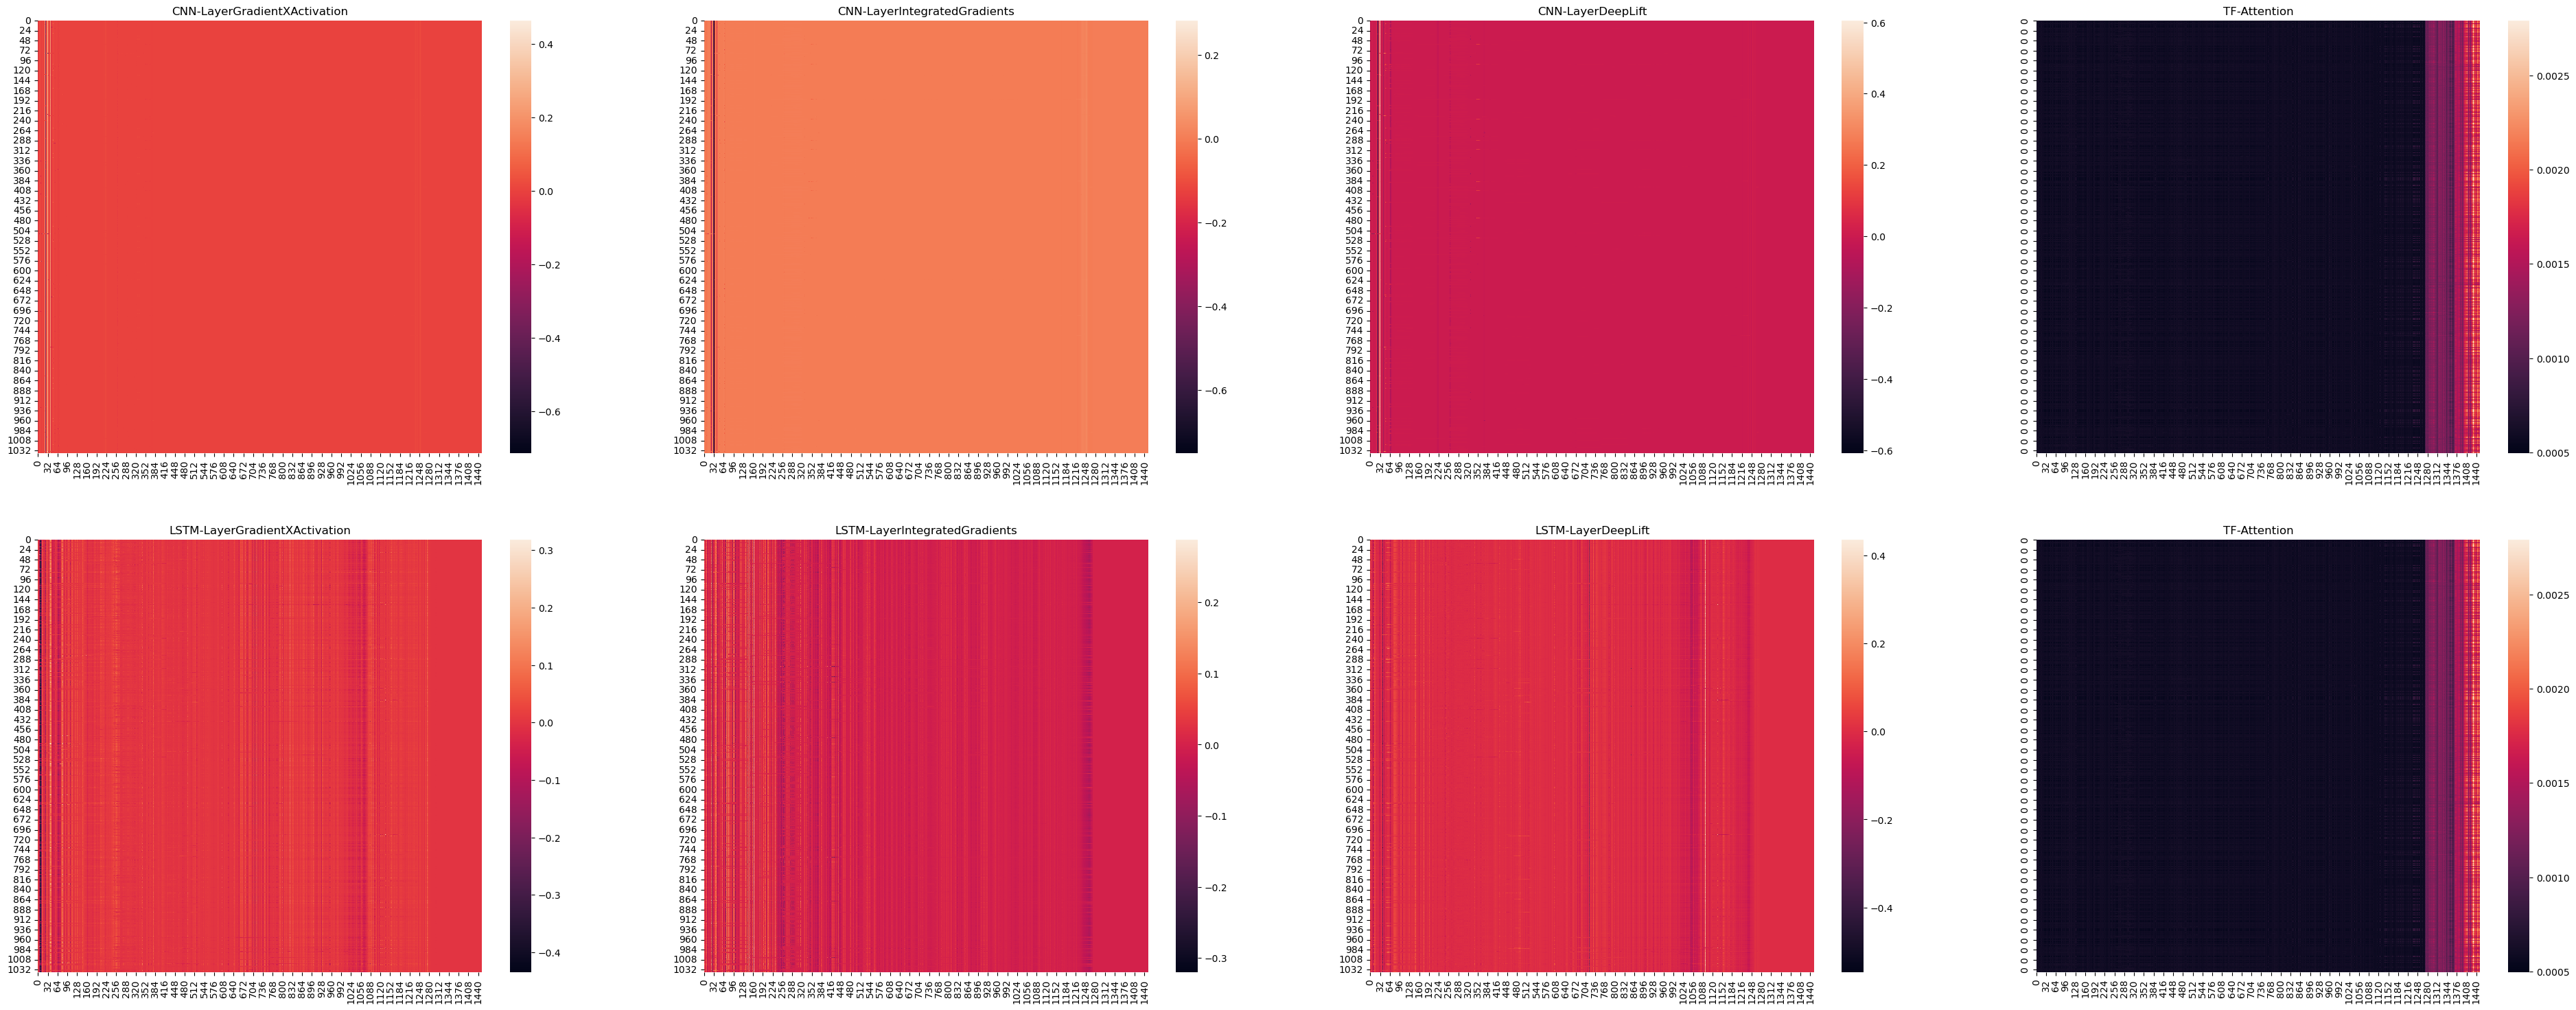

In [80]:
figs, axs = plt.subplots(2, 4, figsize=(48, 18))

def draw_subplot(model, method, class_name, ax):
    entry = list(filter(lambda x: x["model"] == model and x["method"] == method and x["class"] == class_name, n_attr_dfs))[0]
    df = entry["attr_df"]
    sns.heatmap(df, ax=ax)
    ax.set_title(f"{model}-{method}")


# 0, 0: CNN-LayerGradientXActivation
draw_subplot("CNN", "LayerGradientXActivation", "Human", axs[0, 0])

# 0, 1: CNN-LayerIntegratedGradients
draw_subplot("CNN", "LayerIntegratedGradients", "Human", axs[0, 1])

# 0, 2: CNN-LayerDeepLift
draw_subplot("CNN", "LayerDeepLift", "Human", axs[0, 2])

# 0, 3: TF-Attention
draw_subplot("TF", "Attention", "Human", axs[0, 3])

# 1, 0: LSTM-LayerGradientXActivation
draw_subplot("LSTM", "LayerGradientXActivation", "Human", axs[1, 0])

# 1, 1: LSTM-LayerIntegratedGradients
draw_subplot("LSTM", "LayerIntegratedGradients", "Human", axs[1, 1])

# 1, 2: LSTM-LayerDeepLift
draw_subplot("LSTM", "LayerDeepLift", "Human", axs[1, 2])

# 1, 3: TF-Attention
draw_subplot("TF", "Attention", "Human", axs[1, 3])

plt.show()

### Single Sequence Attribution Value Analysis

In [81]:
# compute ranks
for entry in single_seq_attr_dfs:
    attr_df = entry["attr_df"]
    attr = attr_df.iloc[0, :].values
    attr_abs = np.abs(attr)
    # top 20 attr values
    entry["top_n_attr"] = np.argsort(attr_abs)[-20:]

In [82]:
entry

{'model': 'TF',
 'method': 'Attention',
 'class': 'Human',
 'attr_df':       0         1         2         3         4         5         6     \
 0  0.00055  0.000551  0.000576  0.000552  0.000654  0.000575  0.000647   
 
        7         8         9     ...      1443      1444      1445      1446  \
 0  0.000641  0.000566  0.000631  ...  0.002276  0.002294  0.002196  0.002082   
 
        1447      1448      1449      1450      1451      1452  
 0  0.002031  0.002043  0.002055  0.002042  0.002009  0.001905  
 
 [1 rows x 1453 columns],
 'top_n_attr': array([1433, 1451, 1411, 1447, 1450, 1448, 1449, 1408, 1446, 1442, 1445,
        1432, 1443, 1428, 1444, 1409, 1410, 1431, 1429, 1430])}

In [83]:
df = pd.DataFrame(single_seq_attr_dfs)
df.drop(columns="attr_df", inplace=True)

In [84]:
def jaccard_sim(a, b):
    a = set(a)
    b = set(b)
    union = len(a.union(b))
    intersection = len(a.intersection(b))
    return intersection / union

def jaccard_analysis(df):
    df["model-method"] = df["model"] + "-" + df["method"]
    sim_list = []
    model_method_vals = df["model-method"].unique()
    for val_1 in model_method_vals:
        for val_2 in model_method_vals:
            series_1 = list(df[df["model-method"] == val_1]["top_n_attr"].values[0])
            series_2 = list(df[df["model-method"] == val_2]["top_n_attr"].values[0])
            sim_list.append({
                "model-method-1": val_1,
                "model-method-2": val_2,
                "jaccard_sim": jaccard_sim(series_1, series_2)
            })
    sim_df = pd.DataFrame(sim_list)
    sim_df_pivot = sim_df.pivot(columns="model-method-2", index="model-method-1", values="jaccard_sim")
    sns.heatmap(sim_df_pivot, linewidth=.5)
    plt.show()

#### Jaccard similarity between top 20 positions for different model-method combination pairs - Human class

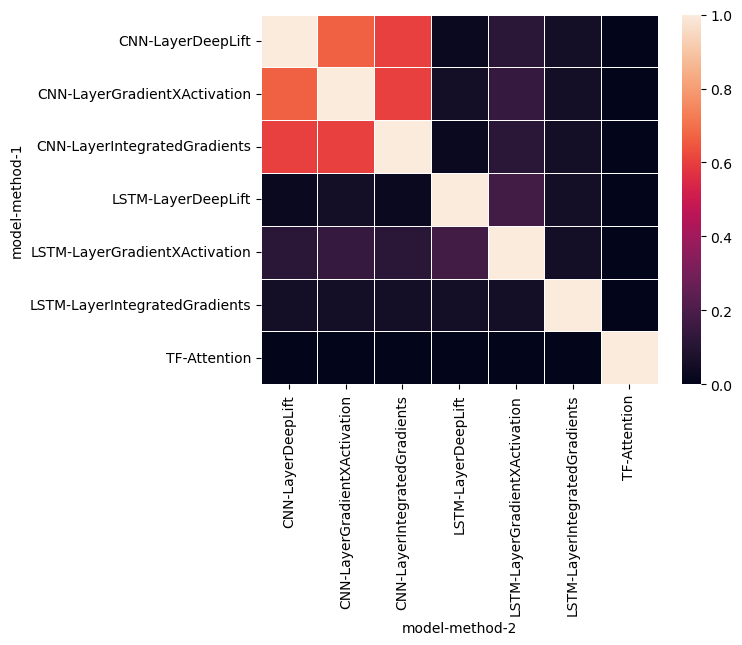

In [85]:
human_df = df[df["class"] == "Human"]
jaccard_analysis(human_df)

In [89]:
df

,model,method,class,top_n_attr,model-method
0,CNN,LayerGradientXActivation,Human,"[2, 30, 43, 22, 35, 8, 21, 67, 44, 40, 29, 66,...",CNN - LayerGradientXActivation
1,LSTM,LayerGradientXActivation,Human,"[1273, 38, 43, 72, 710, 81, 65, 58, 5, 13, 41,...",LSTM - LayerGradientXActivation
2,CNN,LayerIntegratedGradients,Human,"[1249, 8, 1253, 3, 1252, 66, 21, 30, 29, 43, 2...",CNN - LayerIntegratedGradients
3,LSTM,LayerIntegratedGradients,Human,"[60, 73, 281, 143, 267, 136, 98, 26, 0, 148, 6...",LSTM - LayerIntegratedGradients
4,CNN,LayerDeepLift,Human,"[219, 261, 67, 262, 8, 68, 31, 21, 29, 66, 35,...",CNN - LayerDeepLift
5,LSTM,LayerDeepLift,Human,"[1070, 65, 1061, 206, 1071, 244, 12, 1063, 11,...",LSTM - LayerDeepLift
6,TF,Attention,Human,"[1433, 1451, 1411, 1447, 1450, 1448, 1449, 140...",TF - Attention


In [87]:
df["model-method"] = df["model"] + " - " + df["method"]
exploded_df = df.explode("top_n_attr")

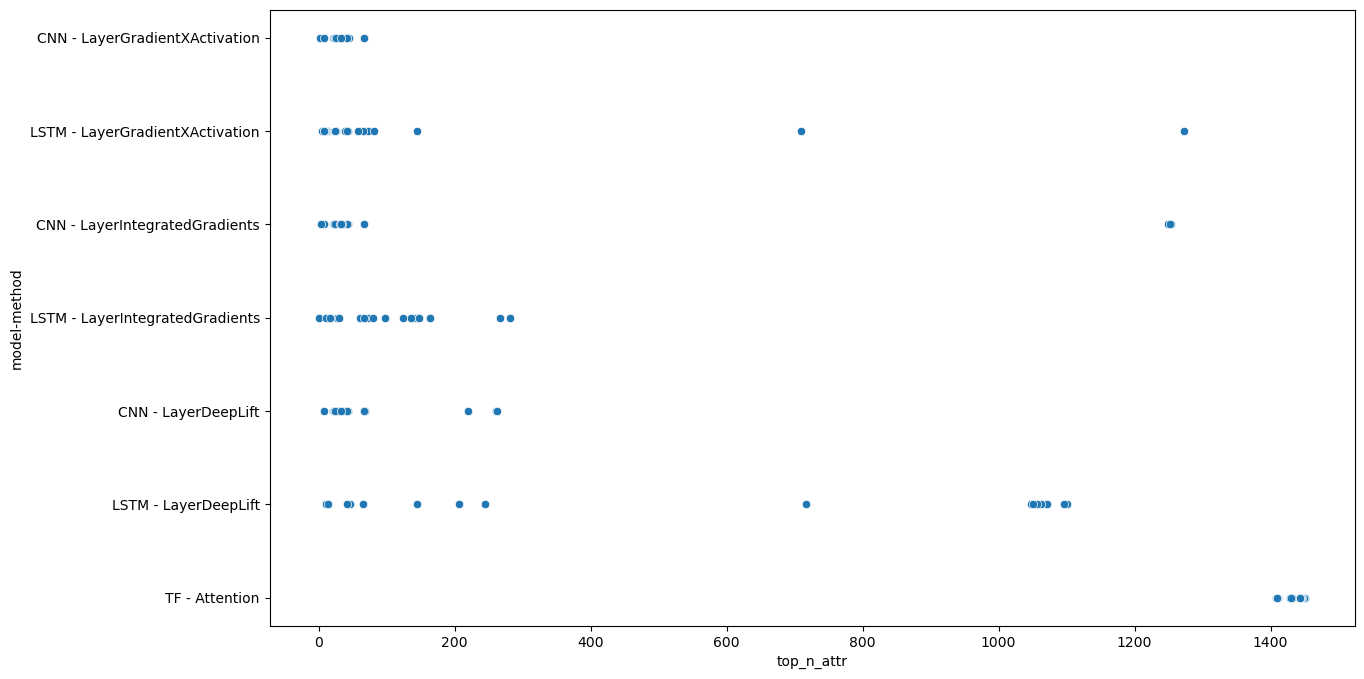

In [88]:
plt.figure(figsize=(14,8))
ax = sns.scatterplot(data=exploded_df[exploded_df["class"] == "Human"], x="top_n_attr", y="model-method")
plt.show()